In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from datetime import datetime
import seaborn as sns
import re
import scipy
from google.ads.googleads.client import GoogleAdsClient
import os
import yaml

sns.set()

In [2]:
if os.path.exists("google_config.yaml"):
    with open("google_config.yaml") as fc:
        conf = yaml.full_load(fc)
        GOOGLE_CREDENTIALS = {
            "developer_token": conf["GoogleDeveloperToken"],
            "refresh_token": conf["GoogleRefreshToken"],
            "client_id": conf["GoogleClientId"],
            "client_secret": conf["GoogleClientSecret"],
            "use_proto_plus": conf["use_proto_plus"],
            "GoogleCustomerAccountId": str(conf["GoogleCustomerAccountId"]),
            "login_customer_id": str(conf["GoogleCustomerAccountId"])}
elif os.environ.get("developer_token"):
    GOOGLE_CREDENTIALS = {
        "developer_token": os.environ.get("developer_token").replace("\n", ""),
        "refresh_token": os.environ.get("refresh_token").replace("\n", ""),
        "client_id": os.environ.get("client_id").replace("\n", ""),
        "client_secret": os.environ.get("client_secret").replace("\n", ""),
        "login_customer_id": os.environ.get("login_customer_id").replace("\n", ""),
        "GoogleCustomerAccountId": os.environ.get("login_customer_id").replace("\n", ""),
        "use_proto_plus": True}

else:
    GOOGLE_CREDENTIALS = None

CLIENT = GoogleAdsClient.load_from_dict(GOOGLE_CREDENTIALS)

In [3]:
ga_service = CLIENT.get_service("GoogleAdsService")
search_request = CLIENT.get_type("SearchGoogleAdsRequest")
query = """
SELECT
	customer_client.client_customer, 
	customer_client.descriptive_name
FROM customer_client
where customer_client.status in ('ENABLED')
and customer_client.test_account = FALSE
"""
search_request.customer_id = GOOGLE_CREDENTIALS['login_customer_id']
search_request.query = query
results = ga_service.search(request=search_request)
rows = []
for row in results:
	if not row.recommendation.dismissed:
		rows.append(
			[
				row.customer_client.client_customer,
				row.customer_client.descriptive_name
			]
		)
df = pd.DataFrame(rows, columns=['client_customer', 'name'])
df['google_customer_id'] = df['client_customer'].apply(lambda x: x.split('/')[1])
df = df[df['google_customer_id']!= '6753304597']
df = df[df['name']!='Test New Account']
df['pj_customer_id'] = df['name'].apply(lambda x: int(x.split('(')[-1].split(')')[0]))
df_cust = df[df['pj_customer_id'].isin([1187,43685,1105,1207,1238])].reset_index(drop = True)
df_cust['start_date'] = None
df_cust.loc[df_cust['pj_customer_id']==1187, 'start_date'] = '2024-08-02'
df_cust.loc[df_cust['pj_customer_id']==43685, 'start_date'] = '2024-08-06'
df_cust.loc[df_cust['pj_customer_id']==1105, 'start_date'] = '2024-08-06'
df_cust.loc[df_cust['pj_customer_id']==1207, 'start_date'] = '2024-08-06'
df_cust.loc[df_cust['pj_customer_id']==1238, 'start_date'] = '2024-08-09'
df_cust

client_customer                          name google_customer_id  \
0  customers/7598502388          Dish Network (43685)         7598502388   
1  customers/4237652933                  Sysco (1105)         4237652933   
2  customers/9735341268                   USAA (1207)         9735341268   
3  customers/5867092374  United Parcel Service (1187)         5867092374   
4  customers/8749329015                  VNSNY (1238)         8749329015   

   pj_customer_id  start_date  
0           43685  2024-08-06  
1            1105  2024-08-06  
2            1207  2024-08-06  
3            1187  2024-08-02  
4            1238  2024-08-09

In [4]:
def get_match_type_data(google_customer_id, start_date):
    ga_service = CLIENT.get_service("GoogleAdsService")
    search_request = CLIENT.get_type("SearchGoogleAdsRequest")
    query = f"""
    SELECT ad_group.name,
           ad_group_criterion.keyword.match_type,
           metrics.cost_micros,
           metrics.impressions,
           metrics.clicks, 
           metrics.conversions
    FROM keyword_view
    WHERE segments.date BETWEEN "{str(start_date)}" AND "2024-10-15"
    """
    print(query)
    search_request.customer_id = google_customer_id
    search_request.query = query
    results = ga_service.search(request=search_request)
    rows = []
    for row in results:
        if not row.recommendation.dismissed:
            rows.append(
                [
                    row.ad_group.name,
                    row.ad_group_criterion.keyword.match_type,
                    row.metrics.cost_micros,
                    row.metrics.impressions,
                    row.metrics.clicks, 
                    row.metrics.conversions
                ]
            )
    df = pd.DataFrame(rows, columns=['ad_group', 'match_type_sort', 'cost', 'impressions', 'clicks', 'applyclicks'])
    df = df[df['ad_group'].str.contains('Applications')]
    #df['keyword'] = df['keyword'].str.replace("\'","")
    df['cost'] = df['cost']/1000000.0
    enum = CLIENT.enums.KeywordMatchTypeEnum
    df['match_type'] = df['match_type_sort'].map({enum.BROAD:'BROAD',
                                             enum.PHRASE:'PHRASE',
                                             enum.EXACT:'EXACT'})
    df = df[df['impressions'] > 0]
    df['cpc'] = df.apply(lambda x: x['cost']/x['clicks'] if x['clicks'] > 0 else 0.0, axis = 1)
    df['cpac'] = df.apply(lambda x: x['cost']/x['applyclicks'] if x['applyclicks'] > 0 else 0.0, axis = 1)
    df['ctr'] = df.apply(lambda x: x['clicks']/x['impressions'], axis = 1)
    df['cvr'] = df.apply(lambda x: x['applyclicks']/x['clicks'] if x['clicks'] > 0 else 0.0, axis = 1)
    return df

Dish Network (43685)

    SELECT ad_group.name,
           ad_group_criterion.keyword.match_type,
           metrics.cost_micros,
           metrics.impressions,
           metrics.clicks, 
           metrics.conversions
    FROM keyword_view
    WHERE segments.date BETWEEN "2024-08-06" AND "2024-10-15"
    
cost - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.3382

cost - NOT statistically significant different between BROAD & EXACT, T-test P-value 0.0904

cost - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0372

impressions - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.0935

impressions - IS statistically significant different between BROAD & EXACT, T-test P-value 0.0036

impressions - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0015

clicks - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.4402

clicks - NOT s

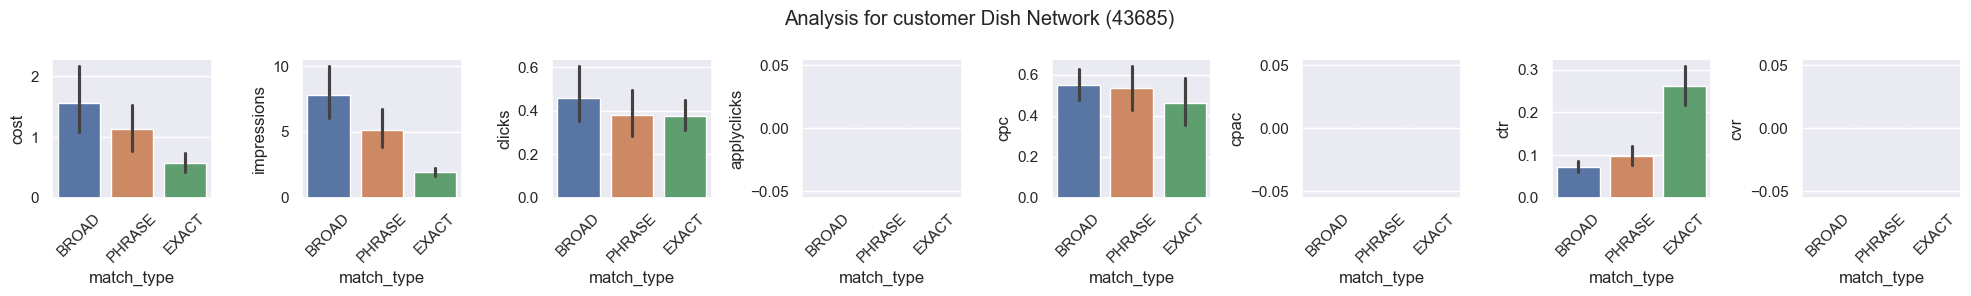

Sysco (1105)

    SELECT ad_group.name,
           ad_group_criterion.keyword.match_type,
           metrics.cost_micros,
           metrics.impressions,
           metrics.clicks, 
           metrics.conversions
    FROM keyword_view
    WHERE segments.date BETWEEN "2024-08-06" AND "2024-10-15"
    
cost - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0

cost - NOT statistically significant different between BROAD & EXACT, T-test P-value 0.433

cost - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0001

impressions - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0

impressions - IS statistically significant different between BROAD & EXACT, T-test P-value 0.0

impressions - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0053

clicks - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0

clicks - IS statistically significant 

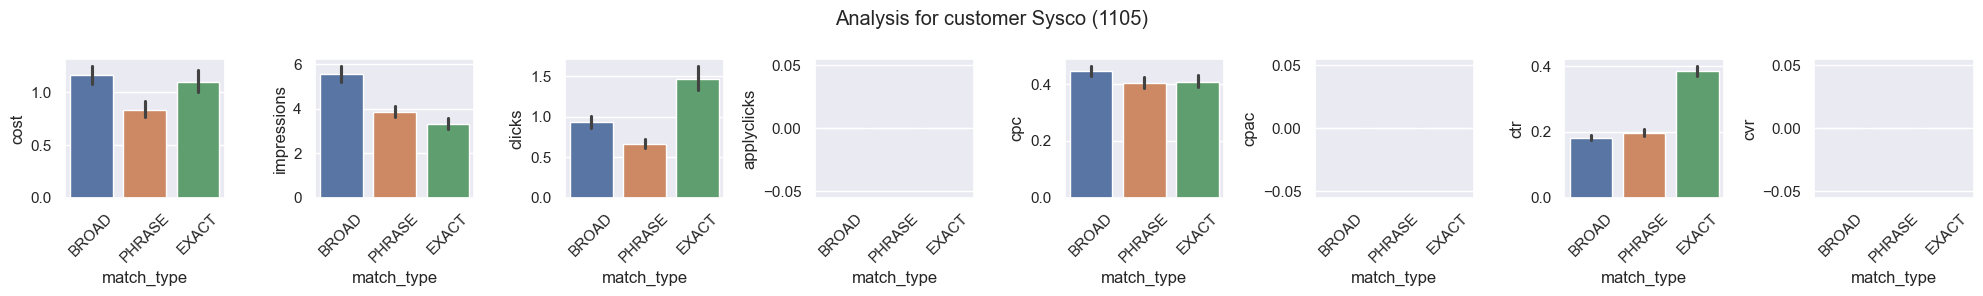

USAA (1207)

    SELECT ad_group.name,
           ad_group_criterion.keyword.match_type,
           metrics.cost_micros,
           metrics.impressions,
           metrics.clicks, 
           metrics.conversions
    FROM keyword_view
    WHERE segments.date BETWEEN "2024-08-06" AND "2024-10-15"
    
cost - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.1294

cost - IS statistically significant different between BROAD & EXACT, T-test P-value 0.0

cost - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0

impressions - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0152

impressions - IS statistically significant different between BROAD & EXACT, T-test P-value 0.0001

impressions - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0231

clicks - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0024

clicks - IS statistically signif

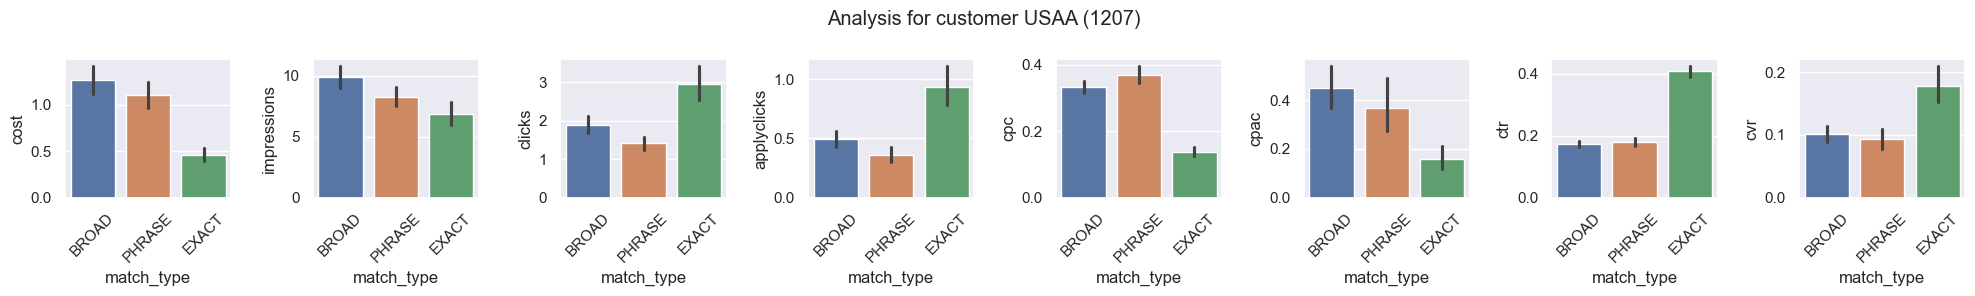

United Parcel Service (1187)

    SELECT ad_group.name,
           ad_group_criterion.keyword.match_type,
           metrics.cost_micros,
           metrics.impressions,
           metrics.clicks, 
           metrics.conversions
    FROM keyword_view
    WHERE segments.date BETWEEN "2024-08-02" AND "2024-10-15"
    
cost - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0

cost - IS statistically significant different between BROAD & EXACT, T-test P-value 0.0

cost - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0

impressions - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0

impressions - IS statistically significant different between BROAD & EXACT, T-test P-value 0.0

impressions - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.0149

clicks - IS statistically significant different between BROAD & PHRASE, T-test P-value 0.0

clicks - IS statistically si

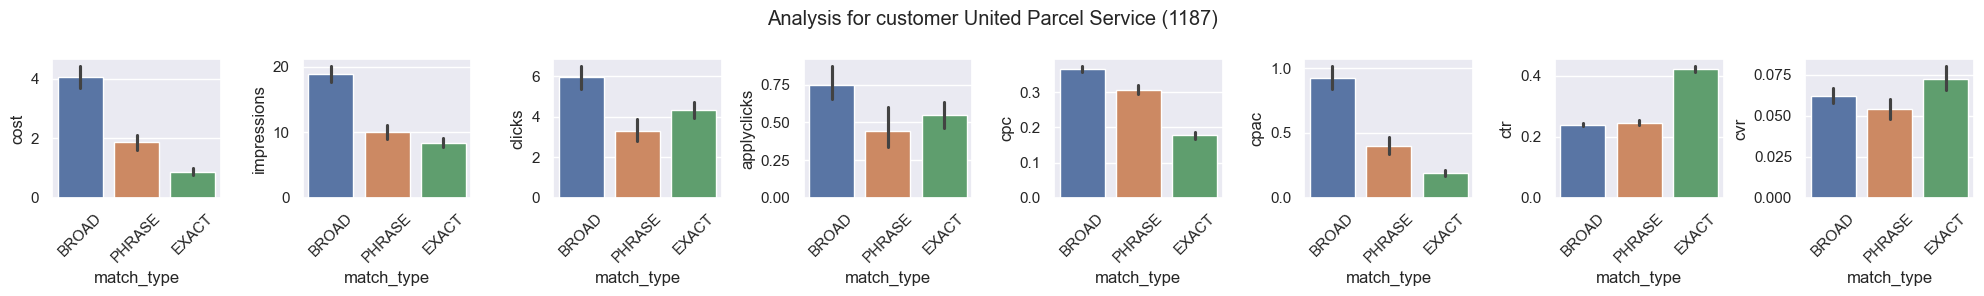

VNSNY (1238)

    SELECT ad_group.name,
           ad_group_criterion.keyword.match_type,
           metrics.cost_micros,
           metrics.impressions,
           metrics.clicks, 
           metrics.conversions
    FROM keyword_view
    WHERE segments.date BETWEEN "2024-08-09" AND "2024-10-15"
    
cost - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.756

cost - NOT statistically significant different between BROAD & EXACT, T-test P-value 0.1283

cost - NOT statistically significant different between PHRASE & EXACT, T-test P-value 0.0523

impressions - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.0743

impressions - NOT statistically significant different between BROAD & EXACT, T-test P-value 0.0688

impressions - IS statistically significant different between PHRASE & EXACT, T-test P-value 0.032

clicks - NOT statistically significant different between BROAD & PHRASE, T-test P-value 0.5806

clicks - IS statistica

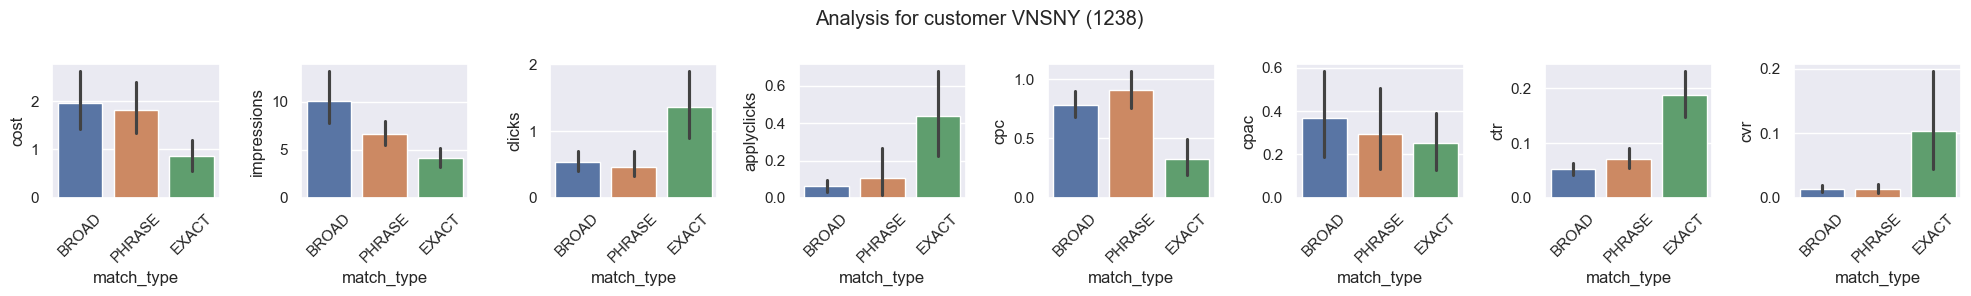

In [6]:
metrics = ['cost', 'impressions', 'clicks', 'applyclicks', 'cpc', 'cpac', 'ctr', 'cvr']
for i, row in df_cust.iterrows():
    print(row['name'])
    df = get_match_type_data(google_customer_id = row['google_customer_id'], start_date = row['start_date'])
    df = df.sort_values('match_type_sort',ascending=False)
    fig, axes = plt.subplots(1, len(metrics), figsize=(20,3))
    fig.suptitle(f'''Analysis for customer {row['name']}''')
    for j in range(len(metrics)): 
        BROAD = df[df['match_type']=='BROAD'][metrics[j]]
        PHRASE = df[df['match_type']=='PHRASE'][metrics[j]]
        EXACT = df[df['match_type']=='EXACT'][metrics[j]]
        statistic, pvalue = scipy.stats.ttest_ind(BROAD, PHRASE)
        if pvalue < 0.05:
            print(metrics[j], '- IS statistically significant different between BROAD & PHRASE, T-test P-value', round(pvalue,4))
        else: 
            print(metrics[j], '- NOT statistically significant different between BROAD & PHRASE, T-test P-value', round(pvalue,4))
        print()
        statistic, pvalue = scipy.stats.ttest_ind(BROAD, EXACT)
        if pvalue < 0.05:
            print(metrics[j], '- IS statistically significant different between BROAD & EXACT, T-test P-value', round(pvalue,4))
        else: 
            print(metrics[j], '- NOT statistically significant different between BROAD & EXACT, T-test P-value', round(pvalue,4))
        print()
        statistic, pvalue = scipy.stats.ttest_ind(PHRASE, EXACT)
        if pvalue < 0.05:
            print(metrics[j], '- IS statistically significant different between PHRASE & EXACT, T-test P-value', round(pvalue,4))
        else: 
            print(metrics[j], '- NOT statistically significant different between PHRASE & EXACT, T-test P-value', round(pvalue,4))
        print()
        sns.barplot(data = df, 
                    x = 'match_type', 
                    y = metrics[j], 
                    hue = 'match_type',
                    ax=axes[j])
        axes[j].set_xticks(df['match_type'].unique())
        axes[j].set_xticklabels(axes[j].get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()